In [21]:
from fba import build_model, read_image, read_trimap, pred
import numpy as np
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from torchvision.models.segmentation import deeplabv3_resnet101




class Args:
    encoder = "resnet50_GN_WS"
    decoder = "fba_decoder"
    weights = "models/FBA.pth"

fba_model = build_model(Args())

modifying input layer to accept 11 channels


In [22]:
def generate_trimap(probs, size, conf_threshold):
    # trimap = (probs > 0.05).astype(float) * 0.5

    pixels = 2 * size + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (pixels, pixels))

    fg = (probs > conf_threshold).astype(float)
    unknown = np.logical_and(probs > 0.1, probs <= conf_threshold).astype(float) * 0.5

    

    fg = cv2.erode(fg, kernel, iterations=1)
    unknown = cv2.dilate(unknown, kernel, iterations=2)

    
    trimap = np.clip(fg + unknown,0,1)
    plt.imshow(trimap)
    plt.show()

    return trimap


def image_to_trimap(image, model, return_seg_mask=False):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

    batch: torch.Tensor = preprocess(image).unsqueeze(0)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch = batch.to(device)
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        output: torch.Tensor = model(batch)["out"][0].softmax(dim=0)

    fg_probs = (1.0 - output[0]).cpu().numpy()

    if return_seg_mask:
        predictions = output.argmax(0).cpu().numpy()
        seg_mask = np.vectorize(lambda pix: 0 if pix == 0 else 255)(predictions)[
            ..., np.newaxis
        ]
        return generate_trimap(fg_probs, 3, 0.9), seg_mask

    return generate_trimap(fg_probs, 3, 0.9)

def fba_trimap(trimap):
    h, w = trimap.shape
    fba_trimap = np.zeros((h, w, 2))
    fba_trimap[trimap == 1, 1] = 1
    fba_trimap[trimap == 0, 0] = 1
    return fba_trimap



In [23]:
model = deeplabv3_resnet101(pretrained=True)

images = [
    Image.open("images/cat_easy.jpg"),
    Image.open("images/cat_hard.jpg"),
    Image.open("images/persons.jpg"),
    Image.open("images/dog.jpg"),
    Image.open("images/dog_easy.jpg"),
]

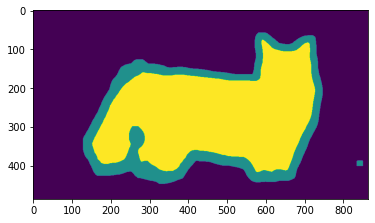

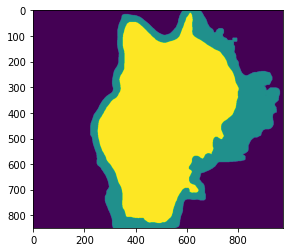

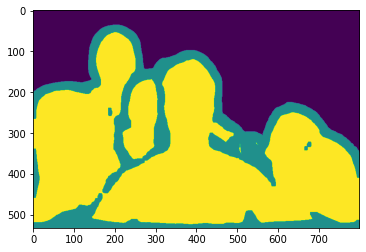

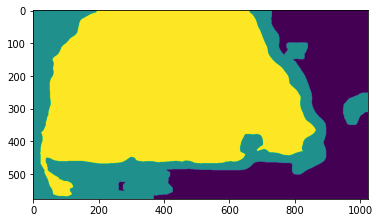

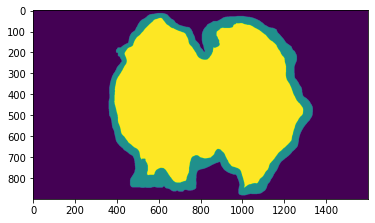

In [24]:
trimaps, seg_masks = map(list, zip(*[image_to_trimap(img,model,return_seg_mask=True) for img in images]))
trimaps = [fba_trimap(trimap) for trimap in trimaps]

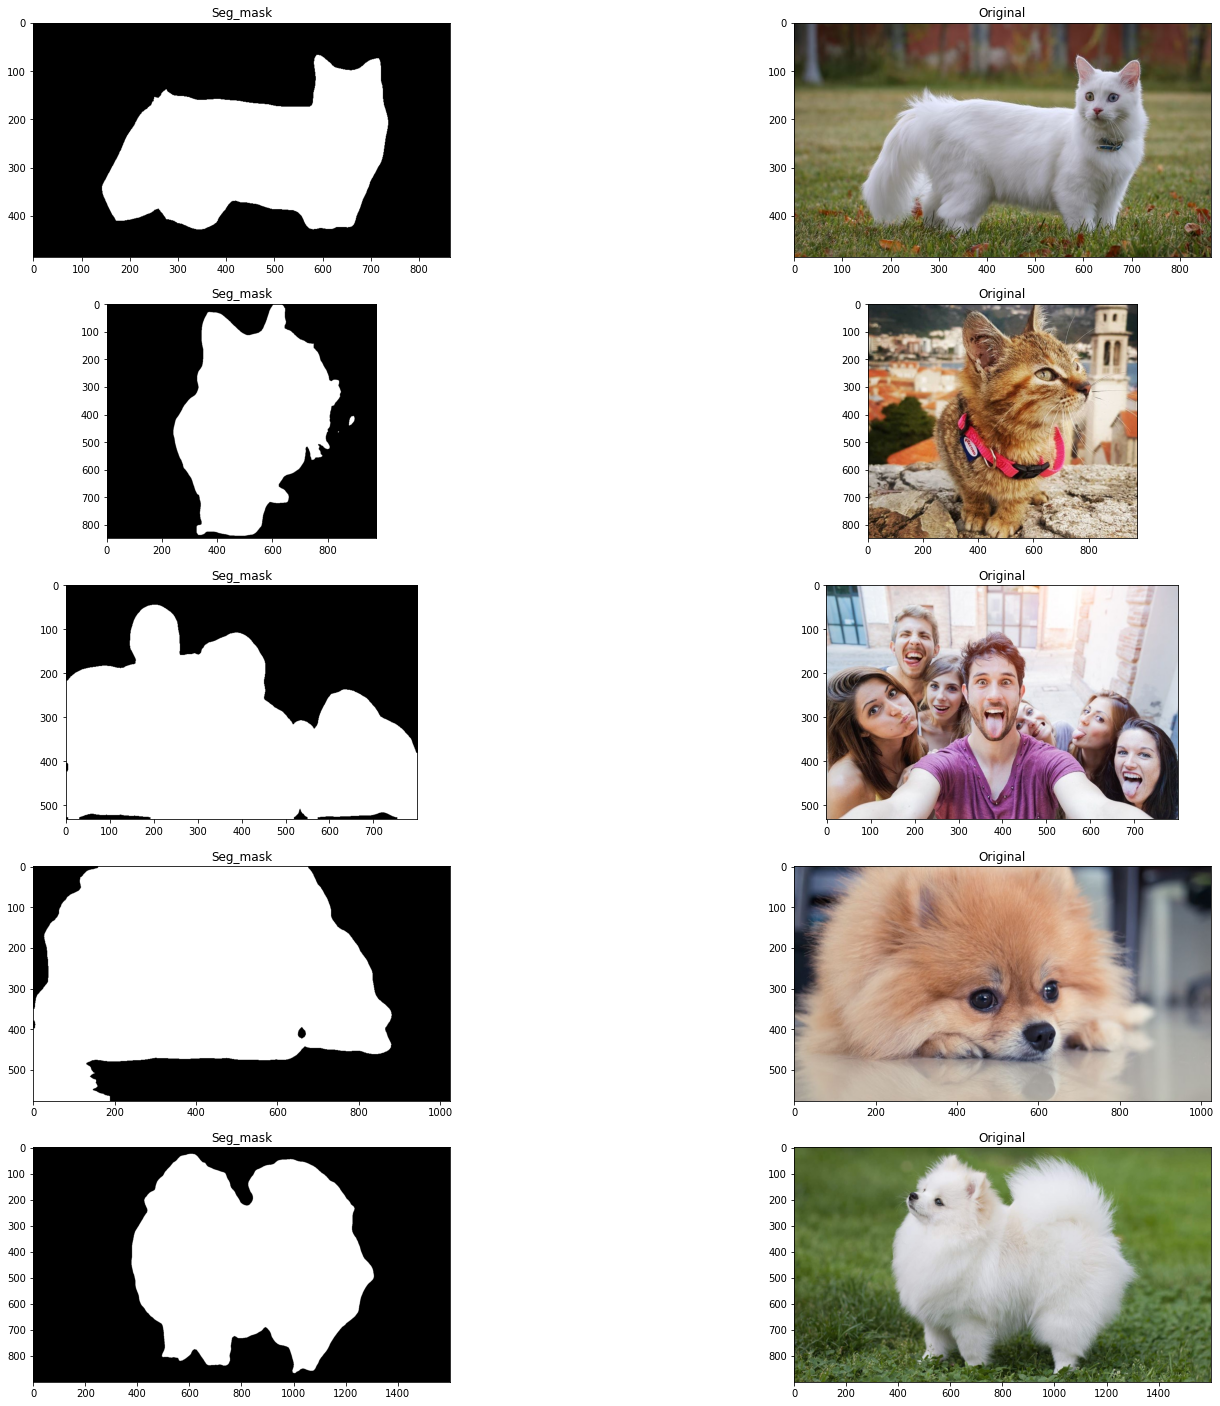

In [19]:
f, axarr = plt.subplots(len(seg_masks), 2, figsize=(25, 25))

for i, (seg_mask, img) in enumerate(zip(seg_masks, images)):
    axarr[i, 0].set_title("Seg_mask")
    axarr[i, 0].imshow(seg_mask, cmap="gray")
    axarr[i, 1].set_title("Original")
    axarr[i, 1].imshow(np.array(img))

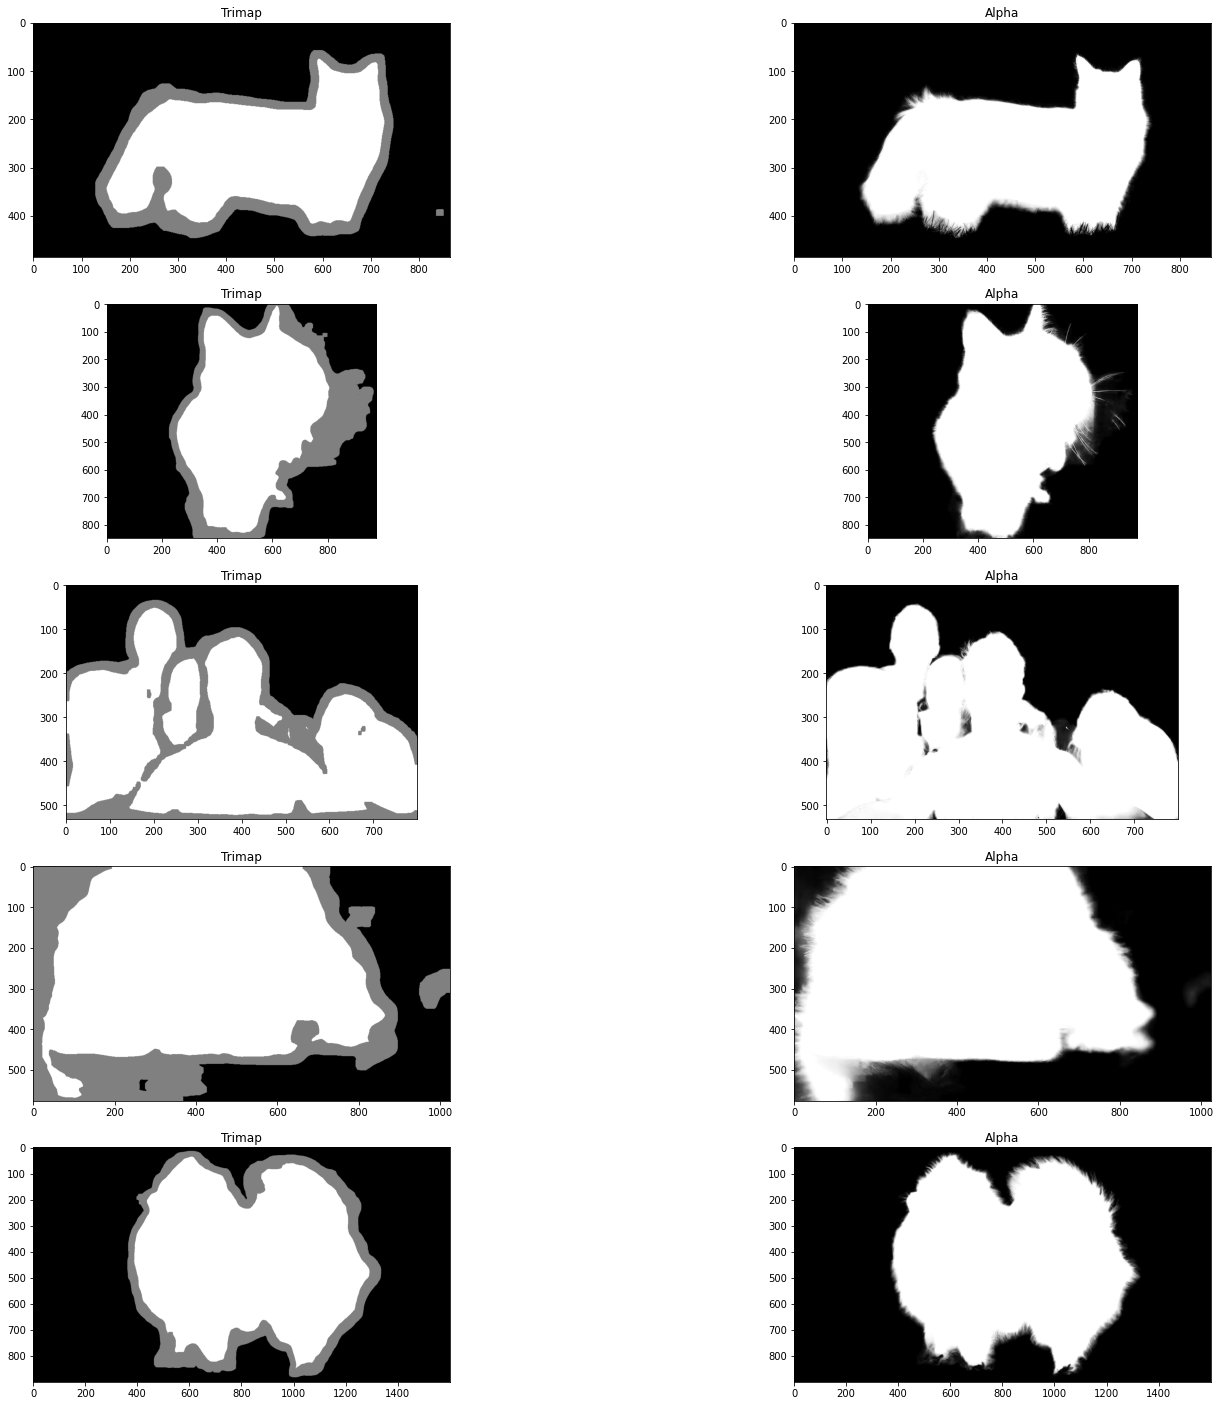

In [26]:
fgs, bgs, alphas = map(
    list,
    zip(
        *[
            pred(np.array(img) / 255, trimap, fba_model)
            for img, trimap in zip(images, trimaps)
        ]
    ),
)


f, axarr = plt.subplots(len(trimaps), 2, figsize=(25, 25))

for i, (alpha, trimap) in enumerate(zip(alphas, trimaps)):
    trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2

    axarr[i, 0].set_title("Trimap")
    axarr[i, 0].imshow(trimap_im, cmap="gray")
    axarr[i, 1].set_title("Alpha")
    axarr[i, 1].imshow(alpha, cmap="gray")

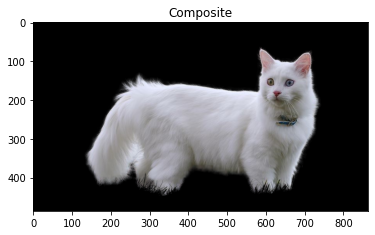

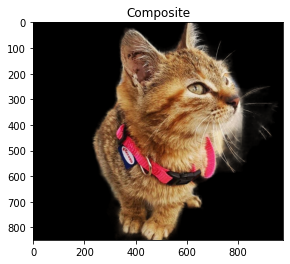

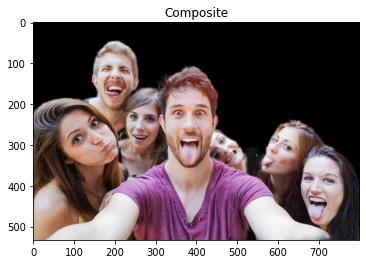

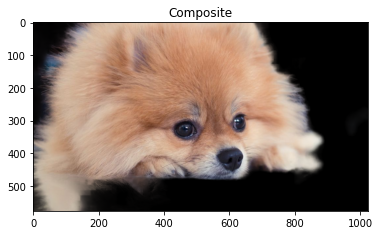

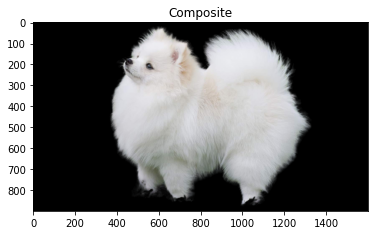

In [29]:
for i,(fg,bg,alpha) in enumerate(zip(fgs,bgs,alphas)):
    r = fg*alpha[:,:,None]
    r = np.clip(r * 255,0,255).astype(np.uint8)
    plt.title('Composite')
    plt.imshow(fg*alpha[:,:,None])
    plt.show()

    cv2.imwrite(f"results/{i}.png",cv2.cvtColor(r,cv2.COLOR_BGR2RGB))